In [45]:
import json
import folium
import random

with open("barris-barrios.json", "r", encoding="utf-8") as f:
    barrios_data = json.load(f)

m = folium.Map(location=[39.4702, -0.3768], zoom_start=12, control_scale=True)

for barrio in barrios_data:
    nombre = barrio['nombre']
    geo_shape = barrio.get('geo_shape', {})

    # Localizamos las coordenadas:
    try:
        coords = geo_shape['geometry']['coordinates'][0]
    except (KeyError, IndexError, TypeError):
        print(f"No se pudieron leer las coordenadas del polígono para {nombre}")
        continue

    coords_latlon = [(c[1], c[0]) for c in coords]

    # Creamos un color aleatorio para cada polígono
    fill_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Añadimos el polígono al mapa
    folium.Polygon(
        locations=coords_latlon,
        color="black",        # Borde
        weight=1.5,           # Grosor del borde
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6,
        popup=nombre
    ).add_to(m)

    center = barrio.get('geo_point_2d')
    if center:
        lat = center['lat']
        lon = center['lon']
        # folium.Marker(
        #     location=[lat, lon],
        #     popup=f"{nombre}",
        #     icon=folium.Icon(color="blue", icon="info-sign")
        # ).add_to(m)

map_filename = "valencia_barrios.html"
m.save(map_filename)
m

In [46]:
area = {}

# Calcular las áreas y almacenarlas
for b1 in barrios_data:
    area[b1['nombre']] = b1['gis_gis_barrios_area']

# Calcular la media sin contar los valores None
valores_area = [v for v in area.values() if v is not None]
media_area = sum(valores_area) / len(valores_area) if valores_area else 0

# Sustituir los None por la media
for key, value in area.items():
    if value is None:
        area[key] = media_area

area

{"L'HORT DE SENABRE": 4263543.125,
 'CIUTAT JARDI': 5027684.202571428,
 'CAMI DE VERA': 5027684.202571428,
 'EL PALMAR': 5027684.202571428,
 'EL PERELLONET': 5027684.202571428,
 'VARA DE QUART': 5027684.202571428,
 'SOTERNES': 5027684.202571428,
 'LA FONTSANTA': 5027684.202571428,
 'EL BOTANIC': 3701155.9375,
 'BORBOTO': 5027684.202571428,
 'BENIFARAIG': 14228152.5,
 'TORMOS': 279952.0,
 'SANT ANTONI': 2497340.9375,
 'BENIMACLET': 7431831.875,
 'MARXALENES': 3903659.375,
 'EXPOSICIO': 3816096.875,
 'BETERO': 2553075.3125,
 'CABANYAL-CANYAMELAR': 1349264.0,
 'MESTALLA': 8435878.75,
 'EL PILAR': 1616061.5625,
 'EL PLA DEL REMEI': 3869178.4375,
 'ALBORS': 2560381.0938,
 'ARRANCAPINS': 8743740.625,
 'EN CORTS': 3640261.875,
 'POBLE NOU': 5027684.202571428,
 'LA TORRE': 5027684.202571428,
 'SANT FRANCESC': 4386583.125,
 'PENYA-ROJA': 9111358.75,
 'ELS ORRIOLS': 5027684.202571428,
 'FAVARA': 2802505.625,
 'CAMI REAL': 1477502.0,
 'LA FONTETA S.LLUIS': 2388267.3438,
 'LA PUNTA': 5027684.20257

In [47]:
import math
dist_matrix = {}
for b1 in barrios_data:
    for b2 in barrios_data:
        lat1, lon1 = b1["geo_point_2d"]["lat"], b1["geo_point_2d"]["lon"]
        lat2, lon2 = b2["geo_point_2d"]["lat"], b2["geo_point_2d"]["lon"]
        dist = math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) * 110  # Aproximación en km
        if dist == 0.0:
            # dist = math.sqrt(area[b1['nombre']])
            dist = random.uniform(1, 3)
        dist_matrix[(b1["nombre"], b2["nombre"])] = dist
dist_matrix

{("L'HORT DE SENABRE", "L'HORT DE SENABRE"): 1.454450967426306,
 ("L'HORT DE SENABRE", 'CIUTAT JARDI'): 5.51503330014322,
 ("L'HORT DE SENABRE", 'CAMI DE VERA'): 5.781308780841824,
 ("L'HORT DE SENABRE", 'EL PALMAR'): 13.50918134076804,
 ("L'HORT DE SENABRE", 'EL PERELLONET'): 20.10196866241257,
 ("L'HORT DE SENABRE", 'VARA DE QUART'): 1.9786262784797233,
 ("L'HORT DE SENABRE", 'SOTERNES'): 2.984949983049285,
 ("L'HORT DE SENABRE", 'LA FONTSANTA'): 2.537935478531245,
 ("L'HORT DE SENABRE", 'EL BOTANIC'): 2.7611346694193846,
 ("L'HORT DE SENABRE", 'BORBOTO'): 7.443352473523906,
 ("L'HORT DE SENABRE", 'BENIFARAIG'): 8.183791091949265,
 ("L'HORT DE SENABRE", 'TORMOS'): 4.342759257009777,
 ("L'HORT DE SENABRE", 'SANT ANTONI'): 4.52618560299521,
 ("L'HORT DE SENABRE", 'BENIMACLET'): 5.018218492750196,
 ("L'HORT DE SENABRE", 'MARXALENES'): 3.8872806100142205,
 ("L'HORT DE SENABRE", 'EXPOSICIO'): 4.029760188770623,
 ("L'HORT DE SENABRE", 'BETERO'): 6.411114722269834,
 ("L'HORT DE SENABRE", 'C

In [48]:
import os
import math
import random
import json
from itertools import permutations

from Melodie import (
    Config,
    Simulator,
    Scenario,
    DataLoader,
    Environment,
    Agent,
    Model
)

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

###############################################################################
# 1) CONFIG
###############################################################################
class WasteCollectionConfig(Config):
    def __init__(self, total_steps, num_trucks, storage_barrios=[], random_seed=42, data_dir='resultados'):
        super().__init__(
            project_name="waste_collection",
            project_root=os.getcwd(),
            input_folder="input",
            output_folder="output"
        )
        self.total_steps = total_steps
        self.num_trucks = num_trucks
        self.max_capacity_container = 25
        self.max_capacity_truck = 1000
        self.threshold = 0.9  # 90% de la capacidad máxima
        self.cost_per_km = 1
        self.cost_per_truck = 10
        self.storage_barrios = storage_barrios
        self.random_seed = random_seed  # Semilla para reproducibilidad
        self.data_dir = data_dir

###############################################################################
# 2) DATA LOADER
###############################################################################
class WasteCollectionDataLoader(DataLoader):
    def __init__(self, simulator, config, scenario_cls):
        super().__init__(simulator, config, scenario_cls)

    def generate_scenarios(self, manager_type: str):
        scenario = WasteCollectionScenario()
        self.load(scenario)
        return [scenario]

    def load(self, scenario: "WasteCollectionScenario"):
        with open("barris-barrios.json", "r", encoding="utf-8") as f:
            barrios_data = json.load(f)
        scenario.barrios_data = barrios_data

###############################################################################
# 3) SCENARIO
###############################################################################
class WasteCollectionScenario(Scenario):
    def __init__(self):
        super().__init__()
        self.barrios_data = []

    def setup(self):
        pass

###############################################################################
# 4) ENVIRONMENT
###############################################################################
class WasteCollectionEnvironment(Environment):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.barrios = []
        self.dist_matrix = {}
        self.area = {}  # Diccionario para almacenar el área de cada barrio

    def setup(self):
        scenario = self.model.scenario
        self.barrios = scenario.barrios_data
        self._build_dist_matrix()
        self._build_area_dict()

    def _build_dist_matrix(self):
        """Construir la matriz de distancias entre los barrios."""
        for b1 in self.barrios:
            for b2 in self.barrios:
                lat1, lon1 = b1["geo_point_2d"]["lat"], b1["geo_point_2d"]["lon"]
                lat2, lon2 = b2["geo_point_2d"]["lat"], b2["geo_point_2d"]["lon"]
                dist = math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) * 110  # Aproximación en km
                self.dist_matrix[(b1["nombre"], b2["nombre"])] = dist

    def _build_area_dict(self):
        """Construir un diccionario de áreas para cada barrio."""
        # Suponiendo que cada barrio tiene una clave 'area'
        for barrio in self.barrios:
            self.area[barrio["nombre"]] = barrio.get("area", 1000000)  # Valor por defecto si no está presente

    def calculate_route_cost(self, route):
        """Calcular el costo de una ruta sumando las distancias entre barrios consecutivos."""
        cost = 0.0
        for i in range(len(route) - 1):
            cost += self.dist_matrix.get((route[i], route[i + 1]), 0)
        return cost

    def find_shortest_hamiltonian_cycle(self, start_barrio, barrios_subset):
        """
        Encuentra un ciclo hamiltoniano usando el algoritmo del vecino más cercano
        y mejora la ruta con una búsqueda local (Hill Climbing).
        """
        if not barrios_subset:
            return [start_barrio], 0.0

        # Asegurarse de que el barrio de inicio esté en el conjunto
        barrios_to_visit = set(barrios_subset)
        barrios_to_visit.add(start_barrio)

        route = [start_barrio]
        total_cost = 0.0
        current_barrio = start_barrio
        barrios_to_visit.remove(current_barrio)

        while barrios_to_visit:
            # Encuentra el barrio más cercano
            next_barrio = min(
                barrios_to_visit,
                key=lambda b: self.dist_matrix.get((current_barrio, b), float('inf'))
            )
            route.append(next_barrio)
            total_cost += self.dist_matrix.get((current_barrio, next_barrio), 0)
            current_barrio = next_barrio
            barrios_to_visit.remove(next_barrio)

        # Regresar al barrio de inicio para completar el ciclo
        # Eliminamos esta línea para permitir regresar al almacén más cercano
        # route.append(start_barrio)
        # total_cost += self.dist_matrix.get((current_barrio, start_barrio), 0)

        # Aplicar búsqueda local (Hill Climbing) para mejorar la ruta
        improved_route, improved_cost = self.hill_climbing(route, total_cost)
        return improved_route, improved_cost

    def hill_climbing(self, route, current_cost):
        """
        Implementa el algoritmo Hill Climbing para mejorar la ruta existente.
        """
        best_route = route
        best_cost = current_cost
        improved = True

        while improved:
            improved = False
            neighbors = self.generate_neighbors(best_route)
            for neighbor in neighbors:
                neighbor_cost = self.calculate_total_cost(neighbor)
                # Añadir el log de los camiones al costo final solo una vez
                neighbor_cost += math.log(len(self.model.trucks)) if len(self.model.trucks) > 0 else 0
                if neighbor_cost < best_cost:
                    best_route = neighbor
                    best_cost = neighbor_cost
                    improved = True
                    break  # Salir del bucle para reiniciar la búsqueda
            # Si no se encontró una mejora, el bucle se detiene

        return best_route, best_cost

    def generate_neighbors(self, route):
        """
        Genera todas las posibles rutas vecinas cambiando la posición de dos barrios.
        """
        neighbors = []
        # Excluir el primer y último barrio (inicio y fin del ciclo)
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route) - 1):
                if i != j:
                    new_route = route.copy()
                    # Intercambiar dos barrios
                    new_route[i], new_route[j] = new_route[j], new_route[i]
                    neighbors.append(new_route)
        return neighbors

    def calculate_total_cost(self, route):
        """
        Calcula el costo total de una ruta dada.
        """
        total = 0.0
        for i in range(len(route) - 1):
            total += self.dist_matrix.get((route[i], route[i+1]), float('inf'))
        return total

    def apply_kmeans(self, barrios_desbordados, num_clusters):
        """
        Aplica KMeans a las coordenadas de los barrios desbordados para agruparlos en clusters.
        """
        # Obtener las coordenadas de los barrios desbordados
        coords = [(barrio["geo_point_2d"]["lat"], barrio["geo_point_2d"]["lon"]) for barrio in barrios_desbordados]

        if len(coords) < num_clusters:
            kmeans = KMeans(n_clusters=len(coords), random_state=self.model.config.random_seed)
            kmeans.fit(coords)
        else:
            kmeans = KMeans(n_clusters=num_clusters, random_state=self.model.config.random_seed)
            kmeans.fit(coords)

        # Agrupar los barrios en clusters
        barrio_clusters = {i: [] for i in range(num_clusters)}
        for idx, label in enumerate(kmeans.labels_):
            barrio_clusters[label].append(barrios_desbordados[idx])

        return barrio_clusters

    def find_closest_storage_barrio(self, barrio_name):
        """
        Encuentra el barrio almacén más cercano al barrio dado.
        """
        min_dist = float('inf')
        closest_barrio = None
        for storage_barrio in self.model.storage_barrios:
            dist = self.dist_matrix.get((barrio_name, storage_barrio), float('inf'))
            if dist < min_dist:
                min_dist = dist
                closest_barrio = storage_barrio
        return closest_barrio

    def step(self):
        # 1. Generar basura en cada contenedor
        for container in self.model.containers:
            container.generate_waste()

        # 2. Identificar barrios con basura desbordada
        overflowing_barrios = set([c.barrio_name for c in self.model.containers if c.is_full(self.model.config.threshold)])

        if not overflowing_barrios:
            return

        # Filtrar barrios desbordados
        barrios_desbordados = [barrio for barrio in self.barrios if barrio["nombre"] in overflowing_barrios]

        # 3. Aplicar KMeans para asignar barrios desbordados a camiones basados en la proximidad
        barrio_clusters = self.apply_kmeans(barrios_desbordados, self.model.config.num_trucks)

        # 4. Asignar barrios a camiones
        assignments = {truck.truck_id: [] for truck in self.model.trucks}
        for i, truck in enumerate(self.model.trucks):
            assigned_barrios = barrio_clusters[i] if i in barrio_clusters else []
            assignments[truck.truck_id] = [barrio["nombre"] for barrio in assigned_barrios]

        # 5. Asignar rutas a los camiones
        for truck in self.model.trucks:
            assigned_barrios = assignments[truck.truck_id]
            if not assigned_barrios:
                truck.route = [truck.current_storage_barrio]
                truck.cost_incurred = 0.0
                continue

            # Definir el barrio almacén actual como punto de inicio
            start_barrio = truck.current_storage_barrio

            # Calcular ciclo hamiltoniano dentro de los barrios asignados, comenzando en el almacén
            route, _ = self.find_shortest_hamiltonian_cycle(start_barrio, assigned_barrios)

            # Asignar la ruta sin agregar el almacén al final
            truck.route = route

        # 6. Ejecutar las rutas de los camiones
        for truck in self.model.trucks:
            truck.run_route()

###############################################################################
# 5) AGENTS
###############################################################################
class ContainerAgent(Agent):
    def __init__(self, agent_id, model, barrio_name):
        super().__init__(agent_id)
        self.id = agent_id
        self.model = model
        self.barrio_name = barrio_name
        self.current_waste = 0.0

    def setup(self):
        self.max_capacity = self.model.config.max_capacity_container

    def generate_waste(self):
        env = self.model.environment
        dist = env.dist_matrix.get(('RUSSAFA', self.barrio_name), 1)  # Evitar división por cero
        area = env.area.get(self.barrio_name, 1000000)  # Valor por defecto si no está presente
        new_waste = random.uniform(5,10) * (1/(dist + 1)) * (area / 1000000)
        self.current_waste += new_waste
        #print(f"Barrio {self.barrio_name} generó {new_waste:.2f} de basura. Total: {self.current_waste:.2f}")
        # self.current_waste = (random.uniform(90, 99) / 10) * self.max_capacity

    def empty(self):
        #print(f"Barrio {self.barrio_name} ha sido vaciado. Basura antes: {self.current_waste:.2f}")
        self.current_waste = 0.0

    def try_empty(self, max_capacity, current_load):
        if self.current_waste > (max_capacity - current_load):
            self.current_waste -= (max_capacity - current_load)
            return max_capacity, False
        else:
            return current_load + self.current_waste, True

    def is_full(self, threshold=0.9):
        return self.current_waste >= threshold * self.max_capacity

class TruckAgent(Agent):
    def __init__(self, agent_id, model, truck_id, storage_barrio):
        super().__init__(agent_id)
        self.model = model
        self.truck_id = truck_id
        self.current_storage_barrio = storage_barrio  # Barrio almacén actual
        self.route = []
        self.cost_incurred = 0.0
        self.current_load = 0.0

    def setup(self):
        self.max_capacity = self.model.config.max_capacity_truck

    def run_route(self):
        if not self.route:
            #print(f"Camión {self.truck_id} no tiene ruta para este paso.")
            return

        #print(f"Camión {self.truck_id} comienza en {self.current_storage_barrio} y ejecuta la ruta: {self.route} con costo: {self.cost_incurred:.2f}")
        init_pos = self.current_storage_barrio
        total_cost = 0.0
        real_route = [init_pos]
        self.current_load = 0.0

        for next_barrio in self.route[1:]:
            # Calcular el costo entre el barrio actual y el siguiente
            env = self.model.environment
            cost = env.dist_matrix.get((init_pos, next_barrio), 0)
            total_cost += cost * 1
            real_route.append(next_barrio)

            # Intentar vaciar los contenedores en el siguiente barrio
            containers_in_barrio = [c for c in self.model.containers if c.barrio_name == next_barrio and c.is_full()]
            for container in containers_in_barrio:
                self.current_load, is_empty = container.try_empty(self.max_capacity, self.current_load)
                #print(f'Camión {self.truck_id} vació el contenedor {container.id} en {next_barrio}. Carga actual: {self.current_load:.2f}')
                if self.current_load >= self.max_capacity:
                    # Si la carga excede la capacidad, volver al almacén más cercano para descargar
                    closest_storage = env.find_closest_storage_barrio(next_barrio)
                    cost_to_storage = env.dist_matrix.get((next_barrio, closest_storage), 0)
                    total_cost += cost_to_storage * 1
                    real_route.append(closest_storage)
                    #print(f'Camión {self.truck_id} excedió la carga. Volviendo a {closest_storage} para descargar.')
                    self.current_storage_barrio = closest_storage
                    self.current_load = 0.0
                    break  # Salir del loop para reiniciar la ruta desde el almacén

            init_pos = next_barrio

        # Después de completar la ruta, regresar al almacén más cercano
        if real_route[-1] != self.current_storage_barrio:
            env = self.model.environment
            closest_storage = env.find_closest_storage_barrio(real_route[-1])
            if closest_storage != real_route[-1]:
                cost_to_storage = env.dist_matrix.get((real_route[-1], closest_storage), 0)
                total_cost += cost_to_storage * 1
                real_route.append(closest_storage)
                #print(f'Camión {self.truck_id} regresó al almacén más cercano: {closest_storage}')
                self.current_storage_barrio = closest_storage

        self.cost_incurred = total_cost
        self.route = real_route.copy()

###############################################################################
# 6) MODEL
###############################################################################
class WasteCollectionModel(Model):
    def __init__(self, config, scenario, run_id_in_scenario=None, visualizer=None):
        super().__init__(config, scenario, run_id_in_scenario=run_id_in_scenario, visualizer=visualizer)
        self.config = config
        self.scenario = scenario

    def setup(self, time_threshold=3):
        # Establecer la semilla para reproducibilidad
        #random.seed(self.config.random_seed)
        #np.random.seed(self.config.random_seed)

        self.storage_barrios = self.config.storage_barrios
        self.environment = WasteCollectionEnvironment(self)
        self.environment.setup()
        self.time_threshold = time_threshold

        # Seleccionar cuatro barrios almacenes de forma aleatoria con una semilla fija
        all_barrio_names = [barrio["nombre"] for barrio in self.environment.barrios]
        if len(all_barrio_names) < 4:
            raise ValueError("No hay suficientes barrios para seleccionar cuatro almacenes.")
        if len(self.storage_barrios) == 0:
            self.storage_barrios = random.sample(all_barrio_names, 4)
        print(f"Barrios almacenes seleccionados: {self.storage_barrios}")

        # Inicializar contenedores
        self.containers = [
            ContainerAgent(i * 3 + j, self, b["nombre"])
            for i, b in enumerate(self.scenario.barrios_data)
            for j in range(3)
        ]
        for container in self.containers:
            container.setup()

        # Inicializar camiones con barrios almacenes asignados aleatoriamente
        self.trucks = []
        for i in range(self.config.num_trucks):
            storage_barrio = random.choice(list(self.storage_barrios))
            truck = TruckAgent(1000 + i, self, i, storage_barrio)
            truck.setup()
            self.trucks.append(truck)
        print(f"Camiones asignados a almacenes: {[truck.current_storage_barrio for truck in self.trucks]}")

        self.run_data = []

    def run(self):
        for step in range(self.config.total_steps):
            # print(f"\n=== STEP {step + 1} ===")
            self.environment.step()

            maximo = max([truck.cost_incurred for truck in self.trucks]) # Máxima distancia recorrida de entre todos los camiones
            total_time = maximo / 10.0
            if total_time > self.time_threshold:  # Penalización si excede el umbral de tiempo
                penalty = maximo
                #print(f"Penalización aplicada en el paso {step + 1}: {penalty}")
            else:
                penalty = 0.0

            for truck in self.trucks:
                # print(truck.route)
                if len(set(truck.route)) <= 2:
                    additional_penalty = maximo
                else:
                    additional_penalty = 0.0

                step_data = {
                    "step": step + 1,
                    "truck_id": truck.truck_id,
                    "route": truck.route,
                    "cost_incurred": truck.cost_incurred + penalty + additional_penalty
                }
                self.run_data.append(step_data)

        self.save_run_data()

    def save_run_data(self):
        if not os.path.exists(self.config.data_dir):
            os.makedirs(self.config.data_dir)
        
        df = pd.DataFrame(self.run_data)
        num_files = len([x for x in os.listdir(self.config.data_dir) if x.endswith('.csv')])
        
        df.to_csv(os.path.join(self.config.data_dir, f"truck_routes_{num_files + 1}.csv"), index=False)
        print("\nDatos de las rutas guardados en truck_routes_{}.csv".format(num_files + 1))


In [49]:
import time
times = []
num_trucks_list = [3]
total_steps_list = [30]
for num_trucks in  num_trucks_list:
    for total_steps in total_steps_list:
        for simulacion in range(10):
            print(f"Simulación con {num_trucks} y {total_steps}")
            simulator = Simulator(
                config=WasteCollectionConfig(num_trucks = num_trucks ,
                                             total_steps = total_steps),
                scenario_cls=WasteCollectionScenario,
                data_loader_cls=WasteCollectionDataLoader,
                model_cls=WasteCollectionModel
            )
            t1 = time.time()
            simulator.run()
            t2 = time.time()
            times.append(t2-t1)

simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0


Simulación con 3 y 30
Barrios almacenes seleccionados: ['PENYA-ROJA', 'LA TORRE', 'MASSARROJOS', 'TORMOS']
Camiones asignados a almacenes: ['TORMOS', 'LA TORRE', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.409s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.472s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_11.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['ELS ORRIOLS', 'TRES FORQUES', 'SAFRANAR', 'EL GRAU']
Camiones asignados a almacenes: ['EL GRAU', 'EL GRAU', 'ELS ORRIOLS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.468s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.531s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_12.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['LA FONTSANTA', 'NOU MOLES', "L'HORT DE SENABRE", 'SAFRANAR']
Camiones asignados a almacenes: ['SAFRANAR', 'NOU MOLES', 'NOU MOLES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.423s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.505s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_13.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['BORBOTO', 'CIUTAT FALLERA', 'SANT PAU', 'FAVARA']
Camiones asignados a almacenes: ['SANT PAU', 'CIUTAT FALLERA', 'CIUTAT FALLERA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.397s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.466s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_14.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['VARA DE QUART', 'SANT FRANCESC', 'EL BOTANIC', 'LA FONTSANTA']
Camiones asignados a almacenes: ['SANT FRANCESC', 'EL BOTANIC', 'VARA DE QUART']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.373s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.448s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_15.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['MALILLA', "L'ILLA PERDUDA", 'CIUTAT FALLERA', 'CIUTAT DE LES ARTS I DE LES CIENCIES']
Camiones asignados a almacenes: ['CIUTAT FALLERA', 'CIUTAT FALLERA', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.561s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.631s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_16.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['CAMI DE VERA', 'CIUTAT FALLERA', 'LA PUNTA', 'EL BOTANIC']
Camiones asignados a almacenes: ['EL BOTANIC', 'CIUTAT FALLERA', 'CIUTAT FALLERA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.433s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.506s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_17.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['MAHUELLA-TAULADELLA', 'LA TORRE', 'CAMPANAR', 'BENIMACLET']
Camiones asignados a almacenes: ['CAMPANAR', 'MAHUELLA-TAULADELLA', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.518s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.602s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_18.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['EL PERELLONET', 'CIUTAT UNIVERSITARIA', 'LA CREU COBERTA', 'LA CREU DEL GRAU']
Camiones asignados a almacenes: ['LA CREU COBERTA', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.606s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.679s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_19.csv
Simulación con 3 y 30
Barrios almacenes seleccionados: ['TORMOS', 'LA MALVA-ROSA', 'CIUTAT FALLERA', 'SANT ANTONI']
Camiones asignados a almacenes: ['CIUTAT FALLERA', 'CIUTAT FALLERA', 'SANT ANTONI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.363s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.426s.



Datos de las rutas guardados en truck_routes_20.csv


In [50]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict

def get_statistics(num_files_per_exp=10, 
                   num_trucks_list=[1,3,5,6,7], 
                   total_steps_list=[30],
                   resultados_path='resultados/',
                   storage_barrios=[]):
  # Parámetros de experimentación
  # Directorio donde están los resultados
  resultados_path = resultados_path

  # Listar archivos relevantes
  files = [x for x in os.listdir(resultados_path) if x.startswith('truck_routes') and x.endswith('.csv')]
  blocks = len(files) // num_files_per_exp

  # Agrupar archivos por experimentos
  files_rec = []
  for block in range(blocks):
      files_rec.append([f'{resultados_path}/truck_routes_{num_files_per_exp * block + i}.csv' for i in range(1,num_files_per_exp)])

#   print(files_rec)
  # Diccionario para almacenar los resultados
  resultados_dic = {}
  estadisticas2 = []

  # Procesar cada bloque de archivos
  i = 0
  if storage_barrios == []:
    for num_trucks in num_trucks_list:
        for total_steps in total_steps_list:
            if i >= len(files_rec):
                break

            block = files_rec[i]
            costes_totales = []
            barrio_recogidas_list = []  # Lista para almacenar recogidas por barrio de cada dataset en el bloque
            truck_loads = []

            for file in block:
                df = pd.read_csv(file)
                costes_totales.append(df['cost_incurred'].sum())

                # Calcular visitas a barrios para este dataset
                barrio_recogidas = defaultdict(int)
                for _, row in df.iterrows():
                    row_rut = list(set(eval(row['route'])))
                    for barrio in row_rut:
                        if barrio:
                            barrio_recogidas[barrio] += 1
                barrio_recogidas_list.append(barrio_recogidas)

                # Guardar carga de los camiones
                truck_loads.extend(df['cost_incurred'].values)

            # Estadísticas de costes
            mean_cost = np.mean(costes_totales)
            std_cost = np.std(costes_totales)

            # Promediar visitas a barrios
            barrio_recogidas_avg = defaultdict(float)
            for barrio_recogidas in barrio_recogidas_list:
                for barrio, count in barrio_recogidas.items():
                    barrio_recogidas_avg[barrio] += count / len(barrio_recogidas_list)

            # Normalizar por total_steps
            barrio_recogidas_norm = {b: v / total_steps for b, v in barrio_recogidas_avg.items()}


            # Guardar en el diccionario de resultados
            resultados_dic[(num_trucks, total_steps)] = mean_cost

            # Guardar en lista de estadísticas
            estadisticas2.append({
                "num_trucks": num_trucks,
                "total_steps": total_steps,
                "mean_cost": mean_cost,
                "std_cost": std_cost,
                "barrio_recogidas_avg": barrio_recogidas_norm  # Promedio de recogidas normalizado
            })
            # print(estadisticas2)

            i += 1
  else:
    for num_trucks in num_trucks_list:
        for total_steps in total_steps_list:
            for storage_barrio in storage_barrios:
                # print(storage_barrio)
                if i >= len(files_rec):
                    break

                block = files_rec[i]
                costes_totales = []
                barrio_recogidas_list = []  # Lista para almacenar recogidas por barrio de cada dataset en el bloque
                truck_loads = []

                for file in block:
                    df = pd.read_csv(file)
                    costes_totales.append(df['cost_incurred'].sum())

                    # Calcular visitas a barrios para este dataset
                    barrio_recogidas = defaultdict(int)
                    for _, row in df.iterrows():
                        row_rut = list(set(eval(row['route'])))
                        for barrio in row_rut:
                            if barrio:
                                barrio_recogidas[barrio] += 1
                    barrio_recogidas_list.append(barrio_recogidas)

                    # Guardar carga de los camiones
                    truck_loads.extend(df['cost_incurred'].values)

                # Estadísticas de costes
                mean_cost = np.mean(costes_totales)
                std_cost = np.std(costes_totales)

                # Promediar visitas a barrios
                barrio_recogidas_avg = defaultdict(float)
                for barrio_recogidas in barrio_recogidas_list:
                    for barrio, count in barrio_recogidas.items():
                        barrio_recogidas_avg[barrio] += count / len(barrio_recogidas_list)

                # Normalizar por total_steps
                barrio_recogidas_norm = {b: v / total_steps for b, v in barrio_recogidas_avg.items()}


                # Guardar en el diccionario de resultados
                resultados_dic[(num_trucks, total_steps)] = mean_cost

                # Guardar en lista de estadísticas
                estadisticas2.append({
                    "num_trucks": num_trucks,
                    "total_steps": total_steps,
                    'storage_barrios': storage_barrio,
                    "mean_cost": mean_cost,
                    "std_cost": std_cost,
                    "barrio_recogidas_avg": barrio_recogidas_norm  # Promedio de recogidas normalizado
                })
                # print(estadisticas2)

                i += 1


  # Mostrar los resultados en un DataFrame
  df_estadisticas = pd.DataFrame(estadisticas2)
  return df_estadisticas

In [51]:
df_estadisticas = get_statistics(num_trucks_list=num_trucks_list, total_steps_list=total_steps_list, num_files_per_exp=10)
df_estadisticas

,num_trucks,total_steps,mean_cost,std_cost,barrio_recogidas_avg
0,3,30,4038.541224,462.131873,"{'TORREFIEL': 0.6592592592592593, 'RUSSAFA': 0..."


In [52]:
import matplotlib.pyplot as plt

def draw_graphs(df_estadisticas):
    # Obtener valores únicos de total_steps
    total_steps_values = df_estadisticas["total_steps"].unique()

    # Crear una figura
    plt.figure(figsize=(12, 8))

    # Iterar sobre cada valor único de total_steps y graficar
    for total_steps in total_steps_values:
        subset = df_estadisticas[df_estadisticas["total_steps"] == total_steps]

        plt.errorbar(subset["num_trucks"],
                    subset["mean_cost"],
                    yerr=subset["std_cost"],
                    fmt='o-', capsize=5,
                    label=f"total_steps = {total_steps}")

        # Encontrar el mínimo de cada curva
        min_idx = subset["mean_cost"].idxmin()
        min_x = subset.loc[min_idx, "num_trucks"]
        min_y = subset.loc[min_idx, "mean_cost"]

        # Marcar el mínimo con un punto y una etiqueta
        plt.scatter(min_x, min_y, color='red', zorder=3)
        plt.text(min_x, min_y+200, f"({min_x}, {min_y:.2f})", fontsize=10, verticalalignment="bottom")

    # Aplicar escala logarítmica al eje Y
    plt.xticks(num_trucks_list)
    # Etiquetas y título
    plt.xlabel("Número de camiones")
    plt.ylabel("Costo promedio (log)")
    plt.title("Costo promedio con desviación estándar vs Número de camiones, separado por total_steps")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()

    # Mostrar gráfico
    plt.show()

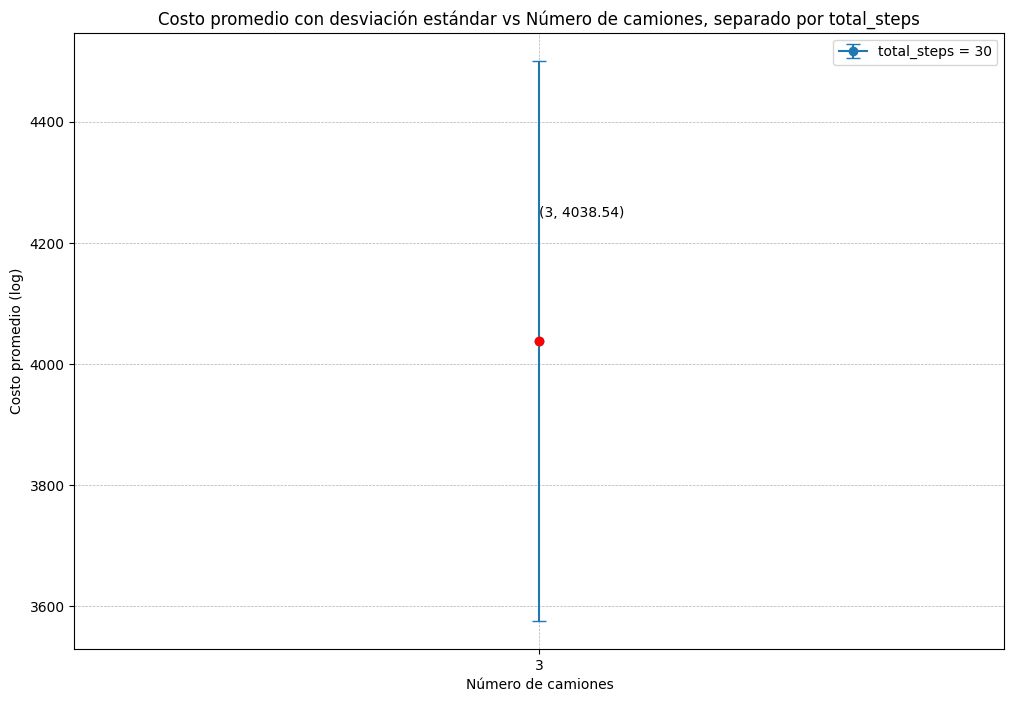

In [53]:
draw_graphs(df_estadisticas)

In [54]:
# import matplotlib.pyplot as plt

# # Extraer valores únicos de total_steps
# total_steps_values = df_estadisticas["total_steps"].unique()

# # Crear figura y ejes
# fig, axes = plt.subplots(nrows=len(total_steps_values), ncols=1, figsize=(10, 12), sharex=True)

# # Paleta de colores
# colors = plt.cm.viridis(np.linspace(0, 1, len(total_steps_values)))

# for ax, total_steps, color in zip(axes, total_steps_values, colors):
#     subset = df_estadisticas[df_estadisticas["total_steps"] == total_steps]

#     # Graficar línea con barra de error
#     ax.errorbar(subset["num_trucks"],
#                 subset["mean_cost"],
#                 yerr=subset["std_cost"],
#                 fmt='o-', capsize=5,
#                 color=color,
#                 label=f"total_steps = {total_steps}")

#     # Encontrar el mínimo de la curva
#     min_idx = subset["mean_cost"].idxmin()
#     min_x = subset.loc[min_idx, "num_trucks"]
#     min_y = subset.loc[min_idx, "mean_cost"]

#     # Marcar el mínimo con un punto y una etiqueta
#     ax.scatter(min_x, min_y, color='red', zorder=3, s=80, edgecolors='black', linewidth=1.2)
#     ax.text(min_x, min_y * 1.1, f"({min_x}, {min_y:.2f})", fontsize=10, verticalalignment="bottom", color='black')

#     # Aplicar escala logarítmica al eje Y
#     ax.set_title(f"Total Steps = {total_steps}", fontsize=12, fontweight='bold')
#     ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

# # Etiquetas generales
# plt.xlabel("Número de camiones", fontsize=12, fontweight='bold')
# fig.supylabel("Coste promedio", fontsize=12, fontweight='bold')
# fig.suptitle("Coste Promedio vs Número de Camiones y Número de Steps", fontsize=14, fontweight='bold')

# # Ajustar espaciado
# plt.xticks(df_estadisticas["num_trucks"].unique())
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Mostrar gráfico
# plt.show()


In [55]:
import matplotlib.colors as mcolors

d = df_estadisticas['barrio_recogidas_avg'].loc[0]
# Crear el mapa centrado en Valencia
m = folium.Map(location=[39.4702, -0.3768], zoom_start=12, control_scale=True)

# Usar una escala de colores de rojo (bajo) a verde (alto)
colormap = mcolors.LinearSegmentedColormap.from_list("custom", ["green", "yellow", "red"])
norm = mcolors.Normalize(vmin=min(d.values()), vmax=max(d.values()))

for barrio in barrios_data:
    nombre = barrio['nombre']
    geo_shape = barrio.get('geo_shape', {})

    # Obtener coordenadas
    try:
        coords = geo_shape['geometry']['coordinates'][0]
    except (KeyError, IndexError, TypeError):
        continue

    coords_latlon = [(c[1], c[0]) for c in coords]

    # Asignar color según el valor del diccionario `d`
    valor = d.get(nombre, 0.0)  # Si no está en `d`, asumimos 0.0
    fill_color = mcolors.to_hex(colormap(norm(valor)))

    # Añadir polígono al mapa
    folium.Polygon(
        locations=coords_latlon,
        color="black",
        weight=1.5,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6,
        popup=f"{nombre}: {valor:.2f}"
    ).add_to(m)

m

In [56]:
from itertools import combinations
from tqdm.notebook import tqdm

all_barrios_name = [b['nombre'] for b in barrios_data]
storage_combs = sorted([set(x) for x in combinations(all_barrios_name, 4)])

print(f'Total of: {len(storage_combs)} combinations...')

KeyboardInterrupt: 

In [30]:
import numpy as np

mean_dist = np.mean(list(dist_matrix.values()))

storage_combs_filter = []
for comb in tqdm(storage_combs):
  aux = combinations(comb, 2)
  if not any([dist_matrix[(x, y)] < 2 * mean_dist for x, y in aux]):
    storage_combs_filter.append(comb)

  0%|          | 0/2331890 [00:00<?, ?it/s]

In [31]:
for comb in storage_combs_filter:
  for _ in range(10):
    simulator = Simulator(config=WasteCollectionConfig(num_trucks=5, 
                                                       total_steps=30, 
                                                       storage_barrios=comb,
                                                       data_dir='resultados_storages'),
                          scenario_cls=WasteCollectionScenario,
                          data_loader_cls=WasteCollectionDataLoader,
                          model_cls=WasteCollectionModel
                          )
    simulator.run()

simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0


Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.11s
    model-run     	 0.573s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.817s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_1.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'LA TORRE', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.515s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.643s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_2.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.467s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.595s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_3.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA TORRE', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.583s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.724s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_4.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.515s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.603s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_5.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.5s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.631s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_6.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.496s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.626s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_7.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA TORRE', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.52s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.653s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_8.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.471s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.615s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_9.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.495s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.628s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_10.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.504s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.624s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_11.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.516s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.647s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_12.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.537s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.627s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_13.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.585s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.717s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_14.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'PENYA-ROJA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.505s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.596s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_15.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.517s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.644s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_16.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.479s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.615s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_17.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'PENYA-ROJA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.558s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.648s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_18.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'MASSARROJOS', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.521s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.66s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_19.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.493s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.638s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_20.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'CAMI REAL', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.482s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.597s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_21.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.531s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.665s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_22.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'EL PALMAR', 'CAMI REAL', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.547s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.665s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_23.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CAMI REAL', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.47s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.557s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_24.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.47s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.604s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_25.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CAMI REAL', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.516s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.614s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_26.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.583s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.706s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_27.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CAMI REAL', 'CAMI REAL', 'EL PALMAR', 'CAMI REAL', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.561s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.645s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_28.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI REAL', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.53s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.663s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_29.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'CAMI REAL', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.512s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.597s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_30.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.525s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.644s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_31.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.565s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.651s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_32.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.511s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.64s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_33.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.555s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.683s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_34.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.59s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.721s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_35.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'LA FONTETA S.LLUIS', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.607s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.706s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_36.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.48s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.562s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_37.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.499s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.638s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_38.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.475s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.603s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_39.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.62s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.752s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_40.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'LA PUNTA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.499s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.632s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_41.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA PUNTA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.465s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.592s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_42.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'LA PUNTA', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.951s
    model-run     	 0.524s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.592s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_43.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA PUNTA', 'LA PUNTA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.501s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.588s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_44.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.494s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.62s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_45.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'LA PUNTA', 'EL PALMAR', 'EL PALMAR', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.458s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.598s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_46.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA PUNTA', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.469s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.597s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_47.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.464s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.556s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_48.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'LA PUNTA', 'MASSARROJOS', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.5s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.623s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_49.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA PUNTA', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'LA PUNTA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.483s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.567s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_50.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'NATZARET', 'NATZARET', 'BENIMAMET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.473s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.6s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_51.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'BENIMAMET', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.514s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.642s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_52.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'RAFALELL-VISTABELLA', 'NATZARET', 'RAFALELL-VISTABELLA', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.533s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.618s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_53.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'EL PALMAR', 'EL PALMAR', 'EL PALMAR', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.479s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.565s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_54.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'BENIMAMET', 'EL PALMAR', 'BENIMAMET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.473s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.606s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_55.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'BENIMAMET', 'EL PALMAR', 'BENIMAMET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.46s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.592s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_56.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'NATZARET', 'NATZARET', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.477s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.605s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_57.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'NATZARET', 'NATZARET', 'BENIMAMET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.497s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.634s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_58.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.484s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.567s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_59.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'NATZARET', 'EL PALMAR', 'NATZARET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.46s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.554s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_60.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.535s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.663s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_61.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'BENIMAMET', 'EL PALMAR', 'BENIMAMET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.498s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.629s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_62.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'BENIMAMET', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.488s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.617s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_63.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL PALMAR', 'BENIMAMET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.485s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.615s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_64.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'EL GRAU', 'EL GRAU', 'EL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.522s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.65s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_65.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'RAFALELL-VISTABELLA', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.021s
    model-run     	 0.497s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.598s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_66.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL GRAU', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.509s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.59s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_67.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.516s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.603s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_68.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'BENIMAMET', 'BENIMAMET', 'EL PALMAR', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.534s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.671s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_69.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'BENIMAMET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.514s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.6s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_70.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.022s
    model-run     	 0.516s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.675s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_71.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.533s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.655s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_72.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.531s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.654s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_73.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.489s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.62s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_74.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'CAMI FONDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.559s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.688s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_75.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.572s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.705s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_76.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.502s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.594s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_77.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'CAMI FONDO', 'CAMI FONDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.023s
    model-run     	 0.532s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.667s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_78.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.543s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.675s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_79.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'CAMI FONDO', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.742s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.888s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_80.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'EL PALMAR', 'MALILLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.518s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.649s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_81.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.529s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.651s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_82.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.537s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.668s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_83.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.577s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.71s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_84.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'MALILLA', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.491s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.586s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_85.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'MASSARROJOS', 'MALILLA', 'MALILLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.506s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.637s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_86.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MALILLA', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.523s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.64s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_87.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'MALILLA', 'MALILLA', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.498s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.584s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_88.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.483s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.625s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_89.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MALILLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.597s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.728s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_90.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.571s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.731s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_91.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.553s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.683s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_92.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.504s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.636s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_93.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.608s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.77s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_94.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'EL PALMAR', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.526s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.657s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_95.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'SANT MARCEL.LI', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.559s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.712s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_96.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'SANT MARCEL.LI', 'SANT MARCEL.LI', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.526s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.67s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_97.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.531s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.67s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_98.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'EL PALMAR', 'EL PALMAR', 'EL PALMAR', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.502s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.634s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_99.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'SANT MARCEL.LI', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.505s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.633s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_100.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'FAITANAR', 'FAITANAR', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.503s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.636s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_101.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'FAITANAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.498s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.633s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_102.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'FAITANAR', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.45s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.577s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_103.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.444s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.578s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_104.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'FAITANAR', 'EL PALMAR', 'FAITANAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.001s
    model-run     	 0.468s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.54s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_105.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'FAITANAR', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.553s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.681s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_106.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'FAITANAR', 'RAFALELL-VISTABELLA', 'FAITANAR', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.497s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.639s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_107.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.493s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.575s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_108.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.958s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.088s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_109.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PALMAR', 'FAITANAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.56s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.677s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_110.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", "EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.459s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.575s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_111.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'EL PALMAR', "EL FORN D'ALCEDO", 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.412s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.492s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_112.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'EL PALMAR', "EL FORN D'ALCEDO", 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.386s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.513s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_113.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.395s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.514s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_114.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.382s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.511s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_115.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', "EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.449s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.524s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_116.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.408s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.526s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_117.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PALMAR', 'EL PALMAR', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.447s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.571s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_118.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'EL PALMAR', 'MASSARROJOS', "EL FORN D'ALCEDO", 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.546s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.671s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_119.csv
Barrios almacenes seleccionados: {'EL PALMAR', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', "EL FORN D'ALCEDO", 'EL PALMAR', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.573s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.664s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_120.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.653s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.742s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_121.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.028s
    model-run     	 0.543s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.655s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_122.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.554s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.643s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_123.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.504s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.601s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_124.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.456s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.537s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_125.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 73.933s
    model-run     	 2.776s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 76.778s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_126.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.781s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.888s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_127.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.023s
    model-run     	 0.616s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.71s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_128.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.601s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.684s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_129.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.024s
    model-run     	 0.589s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.684s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_130.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'NA ROVELLA', 'NA ROVELLA', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.521s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.603s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_131.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'NA ROVELLA', 'EL PALMAR', 'NA ROVELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.678s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.776s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_132.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.548s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.635s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_133.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.416s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.489s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_134.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'NA ROVELLA', 'EL PALMAR', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.45s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.526s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_135.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'NA ROVELLA', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.428s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.506s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_136.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.498s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.578s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_137.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'NA ROVELLA', 'EL PALMAR', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.395s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.525s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_138.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.382s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.459s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_139.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'NA ROVELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.419s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.494s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_140.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.449s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.53s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_141.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'NATZARET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.413s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.507s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_142.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.383s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.445s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_143.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.425s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.499s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_144.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.326s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_145.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'MASSARROJOS', 'NATZARET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.328s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.401s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_146.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'NATZARET', 'EL PALMAR', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.384s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.466s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_147.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.367s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.44s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_148.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'NATZARET', 'EL PALMAR', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.367s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_149.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'NATZARET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.345s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.411s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_150.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL GRAU', 'EL GRAU', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.345s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_151.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.368s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.434s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_152.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL GRAU', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.422s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.485s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_153.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.388s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.457s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_154.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.383s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.457s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_155.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'RAFALELL-VISTABELLA', 'EL GRAU', 'EL GRAU', 'EL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.322s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_156.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.289s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_157.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL GRAU', 'EL GRAU', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.351s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.43s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_158.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.32s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.391s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_159.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.299s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_160.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.315s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_161.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'MASSARROJOS', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.297s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.364s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_162.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.282s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_163.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'MASSARROJOS', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.336s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.403s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_164.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_165.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'EL PALMAR', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.284s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.348s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_166.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.367s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.441s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_167.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.021s
    model-run     	 0.303s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.372s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_168.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.337s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.402s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_169.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.001s
    model-run     	 0.365s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_170.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'AIORA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.278s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_171.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'AIORA', 'AIORA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.279s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.342s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_172.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'MASSARROJOS', 'AIORA', 'AIORA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.283s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.353s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_173.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'EL PALMAR', 'AIORA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.317s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_174.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.39s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_175.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'EL PALMAR', 'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_176.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PALMAR', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.281s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.347s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_177.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PALMAR', 'EL PALMAR', 'RAFALELL-VISTABELLA', 'EL PALMAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.295s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_178.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'RAFALELL-VISTABELLA', 'AIORA', 'MASSARROJOS', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.282s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_179.csv
Barrios almacenes seleccionados: {'EL PALMAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.322s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.402s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_180.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.47s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.524s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_181.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.363s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_182.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA TORRE', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.024s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_183.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'LA TORRE', 'LA TORRE', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.323s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.39s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_184.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA TORRE', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.375s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_185.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'LA TORRE', 'RAFALELL-VISTABELLA', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_186.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.299s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.357s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_187.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'LA TORRE', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.284s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_188.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA TORRE', 'LA TORRE', 'MASSARROJOS', 'LA TORRE', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.37s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.427s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_189.csv
Barrios almacenes seleccionados: {'LA TORRE', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA TORRE', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.333s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.411s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_190.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'PENYA-ROJA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.425s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_191.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'PENYA-ROJA', 'PENYA-ROJA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.273s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.342s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_192.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.281s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.347s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_193.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'EL PERELLONET', 'PENYA-ROJA', 'PENYA-ROJA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.294s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.369s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_194.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.325s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_195.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'PENYA-ROJA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.333s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.396s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_196.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.366s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.45s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_197.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.283s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_198.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'PENYA-ROJA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.295s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.36s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_199.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'PENYA-ROJA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_200.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.27s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.335s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_201.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'CAMI REAL', 'CAMI REAL', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.428s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_202.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI REAL', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.45s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.523s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_203.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'CAMI REAL', 'MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.346s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.421s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_204.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'CAMI REAL', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.405s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_205.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.328s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.401s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_206.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CAMI REAL', 'MASSARROJOS', 'EL PERELLONET', 'CAMI REAL', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.369s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.439s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_207.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.289s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.348s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_208.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.926s
    model-run     	 0.334s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.315s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_209.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'CAMI REAL', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.325s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.401s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_210.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_211.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.442s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.516s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_212.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'LA FONTETA S.LLUIS', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.365s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.441s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_213.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.427s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_214.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.422s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_215.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_216.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'EL PERELLONET', 'EL PERELLONET', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.321s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_217.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.281s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.351s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_218.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.299s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.366s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_219.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.295s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.381s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_220.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.385s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.453s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_221.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'LA PUNTA', 'LA PUNTA', 'LA PUNTA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.405s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.48s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_222.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.372s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.449s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_223.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.399s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.472s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_224.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA PUNTA', 'LA PUNTA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.349s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.41s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_225.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_226.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'LA PUNTA', 'RAFALELL-VISTABELLA', 'LA PUNTA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.285s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.352s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_227.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.345s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.431s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_228.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA PUNTA', 'LA PUNTA', 'LA PUNTA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.346s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.413s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_229.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'LA PUNTA', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'LA PUNTA', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.388s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_230.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'BENIMAMET', 'BENIMAMET', 'PINEDO', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.34s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.397s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_231.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.315s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.383s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_232.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.282s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.35s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_233.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'EL PERELLONET', 'BENIMAMET', 'PINEDO', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_234.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.001s
    model-run     	 0.286s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_235.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'PINEDO', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.362s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.424s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_236.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_237.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'BENIMAMET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.355s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.406s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_238.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'BENIMAMET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.305s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_239.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'BENIMAMET', 'BENIMAMET', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.315s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_240.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'NATZARET', 'NATZARET', 'BENIMAMET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.297s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_241.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'EL PERELLONET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.29s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.36s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_242.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'BENIMAMET', 'NATZARET', 'NATZARET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.415s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_243.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'BENIMAMET', 'BENIMAMET', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.001s
    model-run     	 0.363s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_244.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.309s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.376s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_245.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'RAFALELL-VISTABELLA', 'BENIMAMET', 'NATZARET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.29s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.347s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_246.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'NATZARET', 'NATZARET', 'BENIMAMET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_247.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'NATZARET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.296s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.374s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_248.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'NATZARET', 'RAFALELL-VISTABELLA', 'NATZARET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.301s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_249.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'NATZARET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.456s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_250.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL GRAU', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.381s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_251.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'BENIMAMET', 'EL PERELLONET', 'EL PERELLONET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.298s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_252.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.368s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_253.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL GRAU', 'EL GRAU', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.351s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_254.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'EL PERELLONET', 'BENIMAMET', 'EL GRAU', 'EL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.366s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.448s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_255.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'RAFALELL-VISTABELLA', 'EL GRAU', 'EL PERELLONET', 'BENIMAMET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.023s
    model-run     	 0.31s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.383s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_256.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'BENIMAMET', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.345s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.41s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_257.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL PERELLONET', 'EL GRAU', 'EL GRAU', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.433s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_258.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'BENIMAMET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_259.csv
Barrios almacenes seleccionados: {'BENIMAMET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIMAMET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL GRAU', 'EL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.301s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_260.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'EL PERELLONET', 'CIUTAT FALLERA', 'RAFALELL-VISTABELLA', 'CIUTAT FALLERA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.317s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.373s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_261.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'EL PERELLONET', 'CIUTAT FALLERA', 'CIUTAT FALLERA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.324s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.397s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_262.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'PINEDO', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.305s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_263.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT FALLERA', 'PINEDO', 'CIUTAT FALLERA', 'PINEDO', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.375s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.447s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_264.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT FALLERA', 'RAFALELL-VISTABELLA', 'PINEDO', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.307s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_265.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'PINEDO', 'PINEDO', 'PINEDO', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.324s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.407s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_266.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'CIUTAT FALLERA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.283s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.343s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_267.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'PINEDO', 'CIUTAT FALLERA', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.332s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_268.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'CIUTAT FALLERA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.296s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_269.csv
Barrios almacenes seleccionados: {'CIUTAT FALLERA', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'CIUTAT FALLERA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.413s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_270.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'EL PERELLONET', 'CAMI FONDO', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.315s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_271.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.389s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_272.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.3s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.375s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_273.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.299s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.367s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_274.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.384s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_275.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'CAMI FONDO', 'CAMI FONDO', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.283s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.346s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_276.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.372s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.468s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_277.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'CAMI FONDO', 'CAMI FONDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.421s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_278.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'CAMI FONDO', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.322s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.379s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_279.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'CAMI FONDO', 'MASSARROJOS', 'CAMI FONDO', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_280.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'MALILLA', 'MALILLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.304s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_281.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.021s
    model-run     	 0.296s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.367s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_282.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.328s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_283.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.377s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.442s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_284.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'MALILLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.425s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_285.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'MALILLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.37s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.45s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_286.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.351s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_287.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'EL PERELLONET', 'MALILLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.363s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_288.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MALILLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.019s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.374s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_289.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.384s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.463s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_290.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['BENICALAP', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'PINEDO', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.471s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.548s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_291.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['BENICALAP', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.859s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.247s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_292.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'PINEDO', 'PINEDO', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.393s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_293.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'PINEDO', 'BENICALAP']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.311s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_294.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'PINEDO', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.437s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_295.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['EL PERELLONET', 'BENICALAP', 'PINEDO', 'BENICALAP', 'BENICALAP']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.426s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_296.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.354s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.429s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_297.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.449s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.518s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_298.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['BENICALAP', 'BENICALAP', 'EL PERELLONET', 'BENICALAP', 'BENICALAP']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.383s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.449s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_299.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'BENICALAP'}
Camiones asignados a almacenes: ['PINEDO', 'EL PERELLONET', 'PINEDO', 'BENICALAP', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.326s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_300.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.37s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_301.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'SANT MARCEL.LI', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.342s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.412s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_302.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.372s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.439s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_303.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.419s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.489s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_304.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'SANT MARCEL.LI', 'SANT MARCEL.LI', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.374s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.455s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_305.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'SANT MARCEL.LI', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.33s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.394s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_306.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.321s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_307.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.33s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.401s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_308.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.335s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.408s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_309.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'SANT MARCEL.LI', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.424s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_310.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PERELLONET', 'FAITANAR', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.328s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.422s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_311.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.376s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.452s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_312.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'FAITANAR', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.394s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.486s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_313.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'EL PERELLONET', 'FAITANAR', 'MASSARROJOS', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.413s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_314.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL PERELLONET', 'FAITANAR', 'MASSARROJOS', 'FAITANAR', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.355s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.429s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_315.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'FAITANAR', 'FAITANAR', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.336s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.407s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_316.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.423s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.504s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_317.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.445s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_318.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.355s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.424s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_319.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'FAITANAR', 'RAFALELL-VISTABELLA', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.297s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.361s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_320.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIFERRI', 'BENIFERRI', 'RAFALELL-VISTABELLA', 'BENIFERRI', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.406s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_321.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'BENIFERRI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.362s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_322.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIFERRI', 'PINEDO', 'RAFALELL-VISTABELLA', 'BENIFERRI', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_323.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIFERRI', 'RAFALELL-VISTABELLA', 'BENIFERRI', 'PINEDO', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.371s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.444s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_324.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIFERRI', 'EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'BENIFERRI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.416s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_325.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'EL PERELLONET', 'EL PERELLONET', 'BENIFERRI', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.302s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_326.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['BENIFERRI', 'RAFALELL-VISTABELLA', 'BENIFERRI', 'PINEDO', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.322s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.401s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_327.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'BENIFERRI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.285s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.348s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_328.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'BENIFERRI', 'BENIFERRI', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.021s
    model-run     	 0.331s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.397s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_329.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'BENIFERRI', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'PINEDO', 'RAFALELL-VISTABELLA', 'PINEDO', 'BENIFERRI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.344s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.417s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_330.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'PINEDO', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.397s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.469s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_331.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'PINEDO', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.335s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.411s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_332.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.372s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_333.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.412s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.492s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_334.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.45s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_335.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.346s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.423s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_336.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.431s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_337.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'PINEDO', 'MASSARROJOS', 'MASSARROJOS', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.3s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_338.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.278s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.356s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_339.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'PINEDO', 'PINEDO', 'RAFALELL-VISTABELLA', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.301s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.369s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_340.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'PINEDO', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.299s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.367s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_341.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'SANT PAU', 'SANT PAU', 'SANT PAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.274s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.341s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_342.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT PAU', 'PINEDO', 'SANT PAU', 'RAFALELL-VISTABELLA', 'SANT PAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.379s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_343.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'PINEDO', 'SANT PAU', 'SANT PAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.334s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.409s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_344.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT PAU', 'RAFALELL-VISTABELLA', 'PINEDO', 'EL PERELLONET', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.368s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.442s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_345.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'SANT PAU', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.368s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_346.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT PAU', 'RAFALELL-VISTABELLA', 'PINEDO', 'SANT PAU', 'PINEDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_347.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['PINEDO', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.356s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_348.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.282s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_349.csv
Barrios almacenes seleccionados: {'PINEDO', 'EL PERELLONET', 'SANT PAU', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['SANT PAU', 'SANT PAU', 'EL PERELLONET', 'PINEDO', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.392s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.466s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_350.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.377s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.447s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_351.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.38s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.452s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_352.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['EL PERELLONET', "CASTELLAR-L'OLIVERAL", 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.395s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_353.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', "CASTELLAR-L'OLIVERAL", 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.426s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_354.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', "CASTELLAR-L'OLIVERAL"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.425s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_355.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ["CASTELLAR-L'OLIVERAL", 'RAFALELL-VISTABELLA', "CASTELLAR-L'OLIVERAL", 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.331s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.406s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_356.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.421s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_357.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', "CASTELLAR-L'OLIVERAL"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.337s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.453s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_358.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ["CASTELLAR-L'OLIVERAL", 'EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.337s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.411s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_359.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', "CASTELLAR-L'OLIVERAL"}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', "CASTELLAR-L'OLIVERAL", 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.323s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_360.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', "EL FORN D'ALCEDO", 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.295s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.366s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_361.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', "EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.321s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.388s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_362.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.289s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.36s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_363.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.374s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.439s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_364.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', "EL FORN D'ALCEDO", 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.303s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.374s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_365.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', "EL FORN D'ALCEDO", 'MASSARROJOS', 'MASSARROJOS', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.413s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_366.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.342s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.415s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_367.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", "EL FORN D'ALCEDO", "EL FORN D'ALCEDO", "EL FORN D'ALCEDO", "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.417s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_368.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.375s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.444s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_369.csv
Barrios almacenes seleccionados: {'EL PERELLONET', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', "EL FORN D'ALCEDO", 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.288s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_370.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.334s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.423s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_371.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.412s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.489s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_372.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.003s
    model-run     	 0.364s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.427s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_373.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.321s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.396s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_374.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.864s
    model-run     	 0.289s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.216s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_375.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.366s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_376.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.373s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.437s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_377.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.337s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_378.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.331s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.412s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_379.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'CIUTAT DE LES ARTS I DE LES CIENCIES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.336s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.428s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_380.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_381.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_382.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'NA ROVELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.332s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.396s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_383.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.418s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.489s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_384.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.358s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.438s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_385.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.381s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_386.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.326s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_387.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.443s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_388.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.393s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_389.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'NA ROVELLA', 'NA ROVELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.353s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.424s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_390.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.361s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.433s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_391.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.334s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.408s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_392.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.418s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_393.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.373s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.438s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_394.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.351s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.425s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_395.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'MASSARROJOS', 'MASSARROJOS', 'NATZARET', 'NATZARET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_396.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'NATZARET', 'MASSARROJOS', 'NATZARET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.379s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.459s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_397.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.349s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.413s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_398.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'NATZARET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.335s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.403s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_399.csv
Barrios almacenes seleccionados: {'MASSARROJOS', 'EL PERELLONET', 'NATZARET', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['NATZARET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'NATZARET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.286s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.352s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_400.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL GRAU', 'EL GRAU', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_401.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_402.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.3s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.368s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_403.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.344s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.415s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_404.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.439s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.517s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_405.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL PERELLONET', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.31s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.386s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_406.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL GRAU', 'EL PERELLONET', 'EL GRAU', 'EL GRAU', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.391s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.469s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_407.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_408.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'EL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.304s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.378s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_409.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'EL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'EL PERELLONET', 'EL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_410.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.435s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_411.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_412.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.284s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.358s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_413.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.336s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.405s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_414.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.364s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_415.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.31s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.372s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_416.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.3s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.374s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_417.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'EL PERELLONET', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.327s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.402s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_418.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.324s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_419.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'EL PERELLONET', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.404s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_420.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['AIORA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.296s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_421.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'AIORA', 'AIORA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.286s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.349s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_422.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_423.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['EL PERELLONET', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_424.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.393s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.468s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_425.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'AIORA', 'MASSARROJOS', 'EL PERELLONET', 'EL PERELLONET']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.004s
    model-run     	 0.341s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.405s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_426.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL PERELLONET', 'AIORA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.391s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.465s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_427.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'AIORA', 'AIORA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.375s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_428.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PERELLONET', 'EL PERELLONET', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.397s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.457s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_429.csv
Barrios almacenes seleccionados: {'EL PERELLONET', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'AIORA'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'AIORA', 'RAFALELL-VISTABELLA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.406s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.491s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_430.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.493s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.567s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_431.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['LA TORRE', 'RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.421s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_432.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'LA TORRE', 'LA TORRE', 'LA TORRE', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.323s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_433.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['LA TORRE', 'EL SALER', 'MASSARROJOS', 'LA TORRE', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_434.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA TORRE', 'EL SALER', 'LA TORRE', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.432s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_435.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.331s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.405s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_436.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.416s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.493s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_437.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA TORRE', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'LA TORRE']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.382s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_438.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.301s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.383s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_439.csv
Barrios almacenes seleccionados: {'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA TORRE', 'EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_440.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'EL SALER', 'MASSARROJOS', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_441.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.283s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_442.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'PENYA-ROJA', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.303s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_443.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.44s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_444.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'PENYA-ROJA', 'PENYA-ROJA', 'PENYA-ROJA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.298s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.369s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_445.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.384s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_446.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'PENYA-ROJA', 'RAFALELL-VISTABELLA', 'PENYA-ROJA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.29s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.368s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_447.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.332s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.407s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_448.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['PENYA-ROJA', 'PENYA-ROJA', 'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_449.csv
Barrios almacenes seleccionados: {'PENYA-ROJA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'MASSARROJOS', 'PENYA-ROJA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.308s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.393s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_450.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA', 'EL SALER', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.42s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_451.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'CAMI REAL', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.426s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_452.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['CAMI REAL', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.294s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.358s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_453.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'CAMI REAL', 'EL SALER', 'MASSARROJOS', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_454.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.302s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_455.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI REAL']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.298s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_456.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI REAL', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.29s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.36s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_457.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'CAMI REAL', 'CAMI REAL', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.819s
    model-run     	 0.281s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.168s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_458.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'CAMI REAL', 'EL SALER', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_459.csv
Barrios almacenes seleccionados: {'CAMI REAL', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL SALER', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_460.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS', 'EL SALER', 'MASSARROJOS', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.297s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_461.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'EL SALER', 'LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.363s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.438s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_462.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.383s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_463.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'EL SALER', 'LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.296s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_464.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'LA FONTETA S.LLUIS', 'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.311s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.375s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_465.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.3s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.364s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_466.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.326s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_467.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['LA FONTETA S.LLUIS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.38s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_468.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA FONTETA S.LLUIS', 'MASSARROJOS', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.298s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.373s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_469.csv
Barrios almacenes seleccionados: {'LA FONTETA S.LLUIS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'LA FONTETA S.LLUIS', 'EL SALER', 'LA FONTETA S.LLUIS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_470.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'CAMI FONDO', 'CAMI FONDO', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_471.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CAMI FONDO', 'EL SALER', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_472.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CAMI FONDO', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.356s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.433s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_473.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['MASSARROJOS', 'CAMI FONDO', 'EL SALER', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.343s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.408s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_474.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CAMI FONDO', 'CAMI FONDO', 'CAMI FONDO', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_475.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'CAMI FONDO', 'CAMI FONDO', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.315s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.385s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_476.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'RAFALELL-VISTABELLA', 'CAMI FONDO', 'MASSARROJOS', 'CAMI FONDO']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.368s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_477.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.0s
    model-run     	 0.311s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.369s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_478.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.286s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.355s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_479.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CAMI FONDO'}
Camiones asignados a almacenes: ['CAMI FONDO', 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.371s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_480.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MALILLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.306s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.378s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_481.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.311s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.39s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_482.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MALILLA', 'MASSARROJOS', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.405s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.477s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_483.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'MALILLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.411s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_484.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MALILLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.289s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_485.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'MASSARROJOS', 'MALILLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.39s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_486.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MALILLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.38s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.452s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_487.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MALILLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.355s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.428s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_488.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.34s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_489.csv
Barrios almacenes seleccionados: {'MALILLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MALILLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.323s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.4s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_490.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'EL SALER', 'MASSARROJOS', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.412s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_491.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.32s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_492.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'EL SALER', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.307s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.383s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_493.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'SANT MARCEL.LI', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.386s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_494.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.452s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_495.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.414s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_496.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL SALER', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.328s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.403s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_497.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.415s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_498.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['SANT MARCEL.LI', 'SANT MARCEL.LI', 'EL SALER', 'SANT MARCEL.LI', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.404s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_499.csv
Barrios almacenes seleccionados: {'SANT MARCEL.LI', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'SANT MARCEL.LI', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.313s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.388s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_500.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'FAITANAR', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.017s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.406s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_501.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL SALER', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.406s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_502.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.333s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.41s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_503.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'MASSARROJOS', 'FAITANAR', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.384s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_504.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['EL SALER', 'FAITANAR', 'EL SALER', 'FAITANAR', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.323s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_505.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'EL SALER', 'EL SALER', 'FAITANAR', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.293s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.361s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_506.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER', 'FAITANAR', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.361s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.435s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_507.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['MASSARROJOS', 'FAITANAR', 'MASSARROJOS', 'MASSARROJOS', 'FAITANAR']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.018s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.409s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_508.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['FAITANAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'FAITANAR', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_509.csv
Barrios almacenes seleccionados: {'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'FAITANAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'FAITANAR', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.366s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_510.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'EL SALER', "EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.307s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.374s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_511.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", "EL FORN D'ALCEDO", "EL FORN D'ALCEDO", 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.297s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.363s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_512.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', "EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.285s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.358s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_513.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', "EL FORN D'ALCEDO", "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.31s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.382s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_514.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.338s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.407s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_515.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', 'MASSARROJOS', "EL FORN D'ALCEDO"]


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.348s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.419s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_516.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ["EL FORN D'ALCEDO", 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.015s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.416s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_517.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'EL SALER', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.309s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.379s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_518.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.303s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_519.csv
Barrios almacenes seleccionados: {"EL FORN D'ALCEDO", 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'MASSARROJOS', "EL FORN D'ALCEDO", 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.291s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_520.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.365s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_521.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.378s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.448s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_522.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.396s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.474s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_523.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.371s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.445s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_524.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'EL SALER', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.28s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.346s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_525.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.002s
    model-run     	 0.31s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.377s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_526.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'CIUTAT DE LES ARTS I DE LES CIENCIES', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.295s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.363s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_527.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.364s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_528.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER', 'CIUTAT DE LES ARTS I DE LES CIENCIES']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.421s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_529.csv
Barrios almacenes seleccionados: {'CIUTAT DE LES ARTS I DE LES CIENCIES', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['CIUTAT DE LES ARTS I DE LES CIENCIES', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.32s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.382s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_530.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'EL SALER', 'NA ROVELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.006s
    model-run     	 0.35s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.422s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_531.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['NA ROVELLA', 'EL SALER', 'EL SALER', 'MASSARROJOS', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.007s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.386s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_532.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['NA ROVELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'NA ROVELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.012s
    model-run     	 0.374s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.45s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_533.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'NA ROVELLA', 'MASSARROJOS', 'NA ROVELLA', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.324s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.392s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_534.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.438s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.522s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_535.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER', 'EL SALER', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.364s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.436s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_536.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['NA ROVELLA', 'NA ROVELLA', 'EL SALER', 'NA ROVELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.386s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.478s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_537.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.358s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.43s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_538.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.326s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.397s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_539.csv
Barrios almacenes seleccionados: {'NA ROVELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA', 'EL SALER', 'NA ROVELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.37s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.444s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_540.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.952s
    model-run     	 0.343s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 1.354s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_541.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.318s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.387s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_542.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA CREU DEL GRAU']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.357s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.434s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_543.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.02s
    model-run     	 0.347s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.417s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_544.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.337s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.416s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_545.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.344s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.426s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_546.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['LA CREU DEL GRAU', 'MASSARROJOS', 'LA CREU DEL GRAU', 'LA CREU DEL GRAU', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.334s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.412s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_547.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.304s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.376s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_548.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'LA CREU DEL GRAU', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.008s
    model-run     	 0.292s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.362s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_549.csv
Barrios almacenes seleccionados: {'LA CREU DEL GRAU', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.01s
    model-run     	 0.332s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.405s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_550.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.014s
    model-run     	 0.365s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.444s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_551.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'EL SALER', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.329s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.398s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_552.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'AIORA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.339s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.424s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_553.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['AIORA', 'AIORA', 'EL SALER', 'AIORA', 'AIORA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.312s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.384s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_554.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['AIORA', 'AIORA', 'MASSARROJOS', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.016s
    model-run     	 0.302s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.37s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_555.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.316s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.382s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_556.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'AIORA', 'MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.013s
    model-run     	 0.307s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.375s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_557.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['EL SALER', 'EL SALER', 'MASSARROJOS', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.009s
    model-run     	 0.319s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.393s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_558.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'EL SALER', 'MASSARROJOS']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.005s
    model-run     	 0.314s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.379s.
simulator.py:249 INFO Simulation started - id_scenario = 0, id_run = 0



Datos de las rutas guardados en truck_routes_559.csv
Barrios almacenes seleccionados: {'AIORA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL SALER'}
Camiones asignados a almacenes: ['MASSARROJOS', 'MASSARROJOS', 'EL SALER', 'EL SALER', 'RAFALELL-VISTABELLA']


simulator.py:291 INFO Simulation completed - id_scenario = 0, id_run = 0
    model-setup   	 0.011s
    model-run     	 0.287s
    data-collect  	 0.0s

simulator.py:327 INFO Simulator completed, time elapsed 0.359s.



Datos de las rutas guardados en truck_routes_560.csv


In [32]:
df_statistics = get_statistics(num_files_per_exp=10, 
                               num_trucks_list=[5], 
                               total_steps_list=[30],
                               storage_barrios=storage_combs_filter)
df_statistics

,num_trucks,total_steps,storage_barrios,mean_cost,std_cost,barrio_recogidas_avg
0,5,30,"{EL PALMAR, LA TORRE, MASSARROJOS, RAFALELL-VI...",6255.531222,130.071707,"{'RUSSAFA': 0.9296296296296297, 'LA TORRE': 4...."
1,5,30,"{EL PALMAR, PENYA-ROJA, MASSARROJOS, RAFALELL-...",5469.103639,253.776272,"{'RUSSAFA': 0.9296296296296297, 'PENYA-ROJA': ..."
2,5,30,"{EL PALMAR, CAMI REAL, MASSARROJOS, RAFALELL-V...",5633.930750,151.163041,"{'RUSSAFA': 0.9296296296296297, 'CAMI REAL': 4..."
3,5,30,"{EL PALMAR, MASSARROJOS, LA FONTETA S.LLUIS, R...",5381.736164,84.455181,"{'EL PALMAR': 0.16666666666666666, 'RUSSAFA': ..."
4,5,30,"{EL PALMAR, MASSARROJOS, LA PUNTA, RAFALELL-VI...",6289.523792,45.012481,"{'EL PALMAR': 0.10740740740740742, 'RUSSAFA': ..."
5,5,30,"{EL PALMAR, BENIMAMET, NATZARET, RAFALELL-VIST...",6513.679218,155.965879,"{'EL PALMAR': 0.1037037037037037, 'RUSSAFA': 0..."
6,5,30,"{EL PALMAR, BENIMAMET, EL GRAU, RAFALELL-VISTA...",6906.348073,195.988398,"{'RUSSAFA': 0.9222222222222222, 'EL GRAU': 3.4..."
7,5,30,"{EL PALMAR, MASSARROJOS, RAFALELL-VISTABELLA, ...",5285.308160,190.305313,"{'RUSSAFA': 0.9333333333333333, 'CAMI FONDO': ..."
8,5,30,"{EL PALMAR, MALILLA, MASSARROJOS, RAFALELL-VIS...",5106.586823,212.818369,"{'RUSSAFA': 0.9222222222222222, 'MALILLA': 4.3..."
9,5,30,"{EL PALMAR, SANT MARCEL.LI, MASSARROJOS, RAFAL...",5389.579329,170.608035,"{'RUSSAFA': 0.9296296296296297, 'SANT MARCEL.L..."


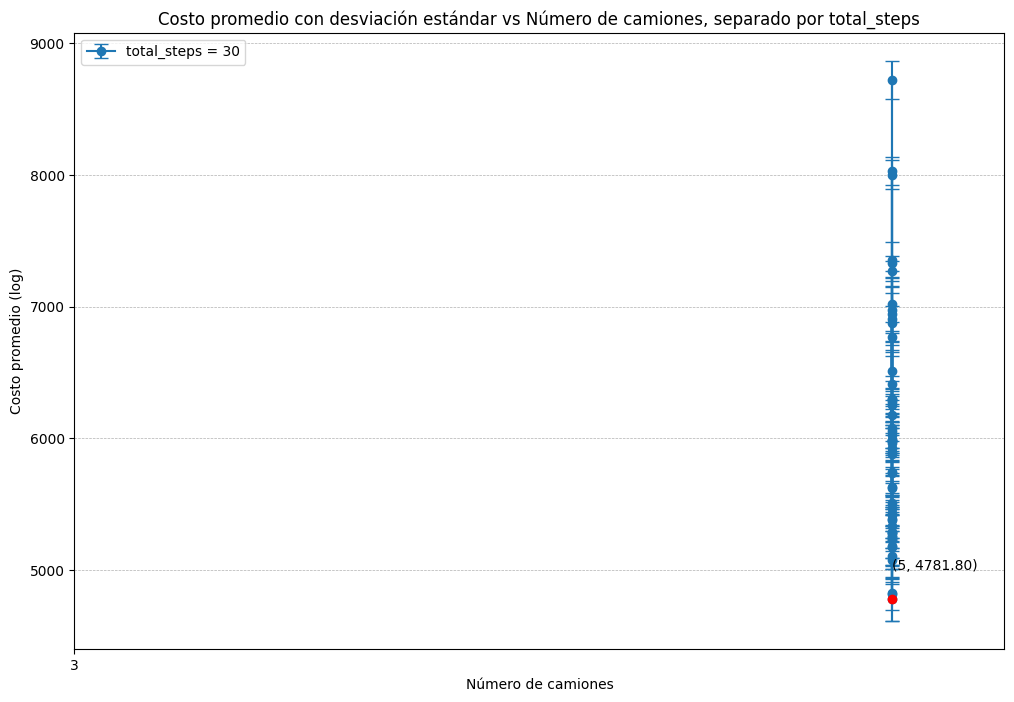

In [33]:
draw_graphs(df_statistics)

In [ ]:
import pandas as pd
import folium
import json
import ast  # For converting route string to Python list
import random  # For generating random colors

# 1. Read the CSV file with routes
routes = pd.read_csv("resultados/truck_routes_26.csv")
# This CSV should have columns like: step, truck_id, route, cost_incurred

# 2. Load neighborhood coordinates from JSON
with open("barris-barrios.json", "r", encoding="utf-8") as f:
    barrios_data = json.load(f)

# Create a dictionary with {neighborhood_name: (lat, lon)}
barrio_coords = {}
for b in barrios_data:
    name = b["nombre"]
    lat = b["geo_point_2d"]["lat"]
    lon = b["geo_point_2d"]["lon"]
    barrio_coords[name] = (lat, lon)

# 3. Assign a unique color to each truck_id
# Generate a color palette or assign predefined colors
# Here, we'll assign random colors to each truck
unique_trucks = routes['truck_id'].unique()
truck_colors = {}
random.seed(42)  # For reproducibility
for truck in unique_trucks:
    # Generate a random color in HEX format
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    truck_colors[truck] = color

# 4. Create a Folium map centered in Valencia (adjust as needed)
valencia_center = [39.4699, -0.3763]  # Adjust to your desired location
m = folium.Map(location=valencia_center, zoom_start=12)

# 5. Organize routes by step
steps = routes['step'].unique()
steps = sorted(steps)  # Optional: sort the steps

# Create a dictionary to hold FeatureGroups for each step
step_layers = {}
for step in steps:
    # Create a FeatureGroup for each step
    fg = folium.FeatureGroup(name=f"Step {step}")
    step_layers[step] = fg
    m.add_child(fg)

# 6. Iterate through the DataFrame and add routes to corresponding step layers
for idx, row in routes.iterrows():
    step = row["step"]
    truck_id = row["truck_id"]
    cost = row["cost_incurred"]

    # The 'route' column is typically a string like "['Barrio1','Barrio2','Barrio3']".
    # Use ast.literal_eval to convert it to a Python list.
    route_str = row["route"]
    try:
        route_list = ast.literal_eval(route_str)
    except:
        route_list = []

    # Convert each neighborhood name to (lat, lon)
    points = []
    for barrio_name in route_list:
        if barrio_name in barrio_coords:
            points.append(barrio_coords[barrio_name])

    # Draw the route with PolyLine if there is more than one point
    if len(points) > 1:
        folium.PolyLine(
            locations=points,
            color=truck_colors.get(truck_id, "blue"),  # Use the truck's color
            weight=3,
            tooltip=f"Truck {truck_id}, Step {step}, Cost={cost:.2f}"
        ).add_to(step_layers[step])

        # Marker for start
        folium.Marker(
            location=points[0],
            popup=f"Start (Truck {truck_id}, Step {step})",
            icon=folium.Icon(color='green')
        ).add_to(step_layers[step])

        # Marker for end
        folium.Marker(
            location=points[-1],
            popup=f"End (Truck {truck_id}, Step {step})",
            icon=folium.Icon(color='red')
        ).add_to(step_layers[step])

    # If the route has a single point, draw a unique marker
    elif len(points) == 1:
        folium.Marker(
            location=points[0],
            popup=f"Single Point Route - Truck {truck_id}, Step {step}",
            icon=folium.Icon(color=truck_colors.get(truck_id, "blue"))
        ).add_to(step_layers[step])

# 7. Add a layer control to the map to toggle steps
folium.LayerControl(collapsed=False).add_to(m)

# 8. (Optional) Add a legend for truck colors
# Create a HTML string for the legend
legend_html = '''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: auto;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     ">
     <b>Truck Colors</b><br>
'''
for truck, color in truck_colors.items():
    legend_html += f'&nbsp;<i style="background:{color};width:10px;height:10px;display:inline-block;"></i>&nbsp;Truck {truck}<br>'
legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# 9. Add neighborhood markers
for barrio in barrios_data:
    nombre = barrio['nombre']
    geo_shape = barrio.get('geo_shape', {})

    # Localizamos las coordenadas:
    try:
        coords = geo_shape['geometry']['coordinates'][0]
    except (KeyError, IndexError, TypeError):
        print(f"No se pudieron leer las coordenadas del polígono para {nombre}")
        continue

    coords_latlon = [(c[1], c[0]) for c in coords]

    # Añadimos el polígono al mapa
    folium.Polygon(
        locations=coords_latlon,
        color="black",        # Borde
        weight=0.5,           # Grosor del borde
        fill=True,
        fill_color="#FFFF00",  # Color de relleno, amarillo
        fill_opacity=0.01,
        popup=nombre
    ).add_to(m)

    # Agregar un marcador al centro de cada barrio
    if nombre in barrio_coords:
        lat, lon = barrio_coords[nombre]
        folium.Marker(
            location=[lat, lon],
            popup=f"Barrio: {nombre}",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

# 10. Display the map
m
